In [100]:
from pathlib import Path
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from stop_words import get_stop_words
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from ipywidgets import interact
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors.classification import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
import eli5
import scikitplot as skplt

In [2]:
np.random.seed(1337)

In [3]:
init_notebook_mode(connected=True)

In [4]:
%matplotlib inline

In [5]:
def read_articles_as_df(root):
    root = Path(root)
    articles = []
    for p in root.rglob("*.txt"):
        rel_path = p.relative_to(root)
        tag = rel_path.parts[0]
        with open(p, encoding="utf8") as f:
            articles.append({"category": tag, "text": f.read()})
    return pd.DataFrame(articles)

# Text Classification using Machine Learning

By Peter Sandberg

# Who am I?

- Gratuated from indøk in 2016.  Specialization: data w/AI + optimization
- Has been working as a *Data Scientist* in the *Process Automation Team* in Visma IT since then
- The *Process Automation* team works on automating/improving processes using machine learning and other data science techniques

# Goal of presentation

The goal of this presentation is to demonstrate how to create a Machine Learning that learns to predict a *category* given a *text*

<p style="text-align: center;">&nbsp;</p>
<p style="text-align: center;"><span style="font-size: 300%;"><em>Text&nbsp;&rarr; Category</em></span></p>

## Machine learning using gradient descent

1. Pick a model that can fit or separate your data
2. Select a way to evaluate the fitness of your model - a *loss function*
3. Use the gradients of the loss function to guide you towards the optimal configurations for your model
4. Start from a random configuration and iterate until the gradients become "too small"

## Gradient descent for linear regression
$$
y = prediction(x) = \sum_iw_ix_i
$$

<center><img src="images/linreg2.png" style="width: 500px;"/></center>

## The loss function

- The loss function is used to evaluate the performance of the model at each iteration of the fitting procedure
- **The gradients/derivatives of this loss function with respect to the model weights will tell us what direction to change the weights to get closer to the minimum loss**

For linear regression, a common loss function is the Mean Squared Error (MSE):

$$
MSE = \frac{1}{N} \sum_{(x,y)\in D} (y - prediction(x))^2
$$

<center><img src="images/mse.png" style="width: 700px;"/></center>

<center><img src="images/linreg.gif" style="width: 1000px;"></center>

## Gradient descent for classification 

The algorithm is the same, the loss function is different

<center><img src="images/logreg.gif" style="width: 800px;"></center>

# Text Classification

1. Get some text data
2. Convert text data into a format that can be used by a Machine Learning model
3. Fit the model
4. Evaluate model
    - Find out if the mistakes can be fixed, and if yes - fix them
    - Go back to step 3

<p style="text-align: center;"><span style="font-size: 300%;"><em>Text&nbsp;&rarr; Category</em></span></p>

# Step 1: get some data

News from vg.no

In [6]:
df = read_articles_as_df("data/vg_nyheter")
df.text = df.text.str.replace("Her kan du lese mer om$", "", regex=True)

In [7]:
df.shape

(4400, 2)

In [8]:
sample = df.sample(frac=1)
sample.head()

,category,text
1539,politikk,De 25 mest leste meningene i året som gikk \nH...
3053,sjakk,Verdensmesteren i hurtigsjakk trues med straff...
491,krim,Slik skal Valdres-moren hjelpes under rettssak...
305,krim,Krever 18 års fengsel for drapet på Janne Jemt...
2438,sjakk,Knockout for kreativiteten! \n (Magnus Carlse...


In [9]:
print(sample.iloc[0].text[:1000]+"...")

De 25 mest leste meningene i året som gikk 
Hva har Frank Løke til felles med Listhaug, Støre og Hareide? Han var gjenstand for en av de mest leste kommentarene i VG i 2018. 
Her er de mest leste kommentarene og debattinnleggene publisert av VGs debatt- og kommentaravdeling i år: 
1. Sylvi Listhaug og konspirasjonsteoriene. 
– Det verste var at Sylvi Listhaug fyrte opp under hatet mot Ap. Ikke at hun såret dem som ble rammet av terroren 22. juli. Det hun gjorde er farlig. Livsfarlig, skrev Hanne Skartveit i årets mest leste kommentar, den 17. mars. 
2. Listhaug ble forlatt av sine egne. 
Også nummer to på lista handler om Sylvi Listhaug. 
– Sylvi Listhaug gikk så langt at hun til slutt sto alene, skrev Frithjof Jacobsen, da Listhaug gikk av som justisminister den 20. mars. 
3. Støre har ikke lenger tillit til Giske. 
– Ap-leder Jonas Gahr Støre etterlot liten tvil om at Trond Giskes dager som nestleder i partiet i praksis er over. Men for å redde partiet må det holdes på formalitetene 

## Category distribution

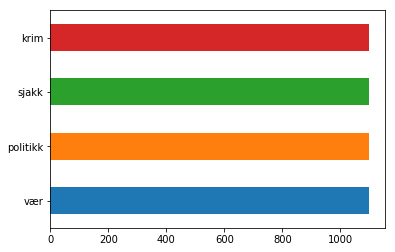

In [10]:
df.category.value_counts().plot.barh();

## Words per category

In [11]:
no_stopwords = get_stop_words("norwegian")

In [103]:
# Pre-compute all word clouds
word_clouds = {}
for c in df.category.unique():
    all_text = " ".join(df[df.category == c].text.str.lower())
    word_clouds[c] = WordCloud(width=800,height=400, background_color="white", stopwords=no_stopwords).generate(all_text)

In [104]:
def plot_word_cloud(category):
    word_cloud = word_clouds[category]
    plt.figure( figsize=(12,6) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show();

In [105]:
interact(plot_word_cloud, category=df.category.unique().tolist());

interactive(children=(Dropdown(description='category', options=('krim', 'politikk', 'sjakk', 'vær'), value='kr…

# Step 2: Converting texts to numbers

- In order to use the texts for machine learning we need to turn them into a format where we can do some math on them
- I.e. we need to turn them into numbers!

In [14]:
pd.set_option('precision',3)

def get_features_as_df(_X, _vec, n=None, shuffle=False):
    if n is None:
        n = _X.shape[0]
    ix = np.arange(_X.shape[1])[np.asarray((_X[:n].sum(axis=0) > 0)).squeeze()] # Select only words being used at least once for the first n rows
    if shuffle:
        np.random.shuffle(ix)
    return pd.DataFrame(_X[:n, ix].todense(), columns=np.asarray(_vec.get_feature_names())[ix])

## "Bag-of-words"

Count the time each word occurs in the text, and create one column/feature per word

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

texts = [
    "This sentence has some words",
    "This other sentence has more words",
    "This sentence has the same word twice ha ha"
]
vec = CountVectorizer()
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,has,more,other,same,sentence,some,the,this,twice,word,words
0,0,1,0,0,0,1,1,0,1,0,0,1
1,0,1,1,1,0,1,0,0,1,0,0,1
2,2,1,0,0,1,1,0,1,1,1,1,0


## Including multi-word terms

In [16]:
vec = CountVectorizer(ngram_range=(1, 2))
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,ha ha,has,has more,has some,has the,more,more words,other,other sentence,...,the,the same,this,this other,this sentence,twice,twice ha,word,word twice,words
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,0,0,1,1,0,0,1,1,1,1,...,0,0,1,1,0,0,0,0,0,1
2,2,1,1,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


## Adding tf-idf weighting

- **Tf**: Weigh a word up if it's used multiple times in the same document
- **idf**: Weighing down a word by an amount proportional to how often it occurs in other documents

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,has,more,other,same,sentence,some,the,this,twice,word,words
0,0.000,0.365,0.000,0.000,0.000,0.365,0.617,0.000,0.365,0.000,0.000,0.469
1,0.000,0.310,0.525,0.525,0.000,0.310,0.000,0.000,0.310,0.000,0.000,0.399
2,0.665,0.196,0.000,0.000,0.332,0.196,0.000,0.332,0.196,0.332,0.332,0.000


## Removing stopwords

In [18]:
vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,sentence,twice,word,words
0,0.000,0.613,0.000,0.000,0.79
1,0.000,0.613,0.000,0.000,0.79
2,0.794,0.234,0.397,0.397,0.00


## Vectorizing the  VG.no texts

In [19]:
%%capture
vec = TfidfVectorizer(min_df=3, max_df=.5, ngram_range=(1, 2), stop_words=no_stopwords)
X = vec.fit_transform(df.text)

In [109]:
get_features_as_df(X, vec, 10, shuffle=True)

,farens grav,lagmannsretten,ulovlig,danske,rekonstruksjon,fortelle,kontaktet,fingeravtrykk,link,forfalskede,...,bevise,30 tiden,egen,madsen 47,ole,tips like,saker,nyåret,forlenget,annen
0,0.000,0.000,0.00,0.000,0.000,0.056,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.00,0.103,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.022,0.048,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.024,0.025,...,0.000,0.000,0.009,0.000,0.000,0.000,0.011,0.000,0.000,0.000
4,0.000,0.000,0.05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.015,0.000,0.023,0.000,0.018,0.000,0.032,0.000
5,0.000,0.031,0.00,0.000,0.046,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.022
7,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.045,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.034,0.000,0.00,0.000,0.033,0.000,0.000,0.000,0.000,0.000,...,0.000,0.023,0.041,0.000,0.000,0.000,0.000,0.027,0.000,0.000
9,0.000,0.000,0.00,0.000,0.000,0.018,0.021,0.086,0.000,0.000,...,0.000,0.045,0.000,0.000,0.000,0.033,0.000,0.000,0.000,0.013


In [24]:
from termcolor import colored
import re

def print_with_highlighting(text, word):
    i = 0
    for match in re.finditer(re.escape(word), text):
        j, k = match.span()
        print(text[i:j], end="")
        print(on_yellow(text[j:k]), end="")
        i = k
    print(text[i:])
              
def on_yellow(text):
    return colored(text, None, 'on_yellow')            

In [110]:
print_with_highlighting(df.iloc[0].text, "fortelle")

Valdres-saken: Moren sendt til sykehus
GJØVIK (VG) Den tiltalte moren skulle forklare seg i retten tirsdag. I 10-tiden ble hun sendt til sykehus med ambulanse. Det samme skjedde da saken var oppe for retten i fjor. 
Klokken 09.36 tok retten for andre gang pause, etter at tiltalte opplyste at hun hadde svelgebesvær og blodsukkerfall. Pressen ble deretter bedt om å forlate rettssalen.
Etter å ha fått tilsyn inne i rettssalen ble kvinnen med ambulansepersonalet. 
– Hun er sendt til sykehus etter å ha fått behandling der inne. Hun hadde et kvalifisert blodsukkerfall som kunne vært livstruende. Hun blir nå utredet og vi må ta det derfra, sier forsvarer Aasmund Olav Sandland. 
Statsadvokat Dymbe sier det vil være svært uheldig å utsette rettssaken enda en gang av hensyn til bevisførsel i saken.
– Nå må vi vente på helsepersonellets vurdering og behandling av henne, men det er retten som må avgjøre videre, sier Dymbe. 
– Er det aktuelt å ha helsepersonell til stede i retten?
– Det må retten v

In [26]:
def plot_tsne(_df, text_col, cat_col, _vec):
    tsne = make_pipeline(
        _vec,
        TruncatedSVD(50),
        Normalizer(copy=False),
        TSNE(n_components=3, random_state=0)
    )
    
    X_tsne_3d = tsne.fit_transform(_df[text_col])
    
    data = []
    for cat in _df.category.unique():
        ix = _df.category == cat
        x, y, z = X_tsne_3d[ix].T
        trace = go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(
                size=10,
                symbol='circle',
                opacity=0.8
            ),
            name=cat
        )
        data.append(trace)
        
    layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
    fig = go.Figure(data, layout=layout)
    iplot(fig)

## Plotting the texts

In [27]:
plot_tsne(df, "text", "category", vec)

## How did we achieve this?

We using a combination *PCA* and *TSNE* to reduce the dimensionality from ~100k down to 3

<center><img src="images/pca.gif" style="width: 1000px;"></center>

# Step 3: Fit a model on the transformed data

Now that we have the texts on a numerical format, we can fit a ML model on it, as described earlier

In [28]:
%%capture
from sklearn.linear_model import LogisticRegression

# Convert the text to numbers
vec = TfidfVectorizer(min_df=3, max_df=.5, ngram_range=(1, 2), stop_words=no_stopwords)
X = vec.fit_transform(df.text)
y = df.category

# Define the model type
model = LogisticRegression()

# Fit the model
model.fit(X, y)

In [29]:
X_test = vec.transform(["Snøstorm i bergen"])
model.predict(X_test)

array(['vær'], dtype=object)

In [30]:
dict(zip(model.classes_, model.predict_proba(X_test)[0]))

{'krim': 0.2601460189494662,
 'politikk': 0.29890029469866825,
 'sjakk': 0.0836356667669016,
 'vær': 0.3573180195849639}

# Step 4: Evaluating performance of model

In [48]:
cv = StratifiedKFold(n_splits=5, random_state=123)
y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

In [49]:
y_pred[:5]

array(['krim', 'krim', 'krim', 'krim', 'krim'], dtype=object)

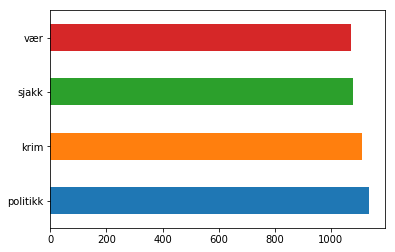

In [50]:
pd.Series(y_pred).value_counts().plot.barh();

In [51]:
accuracy_score(y, y_pred)

0.9775

In [52]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

        krim       0.97      0.98      0.97      1100
    politikk       0.95      0.98      0.96      1100
       sjakk       1.00      0.98      0.99      1100
         vær       1.00      0.97      0.99      1100

   micro avg       0.98      0.98      0.98      4400
   macro avg       0.98      0.98      0.98      4400
weighted avg       0.98      0.98      0.98      4400



## Highest probability, wrong class

In [90]:
y_pred_proba = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method="predict_proba")
y_pred_proba[:3]

array([[0.83004544, 0.08754605, 0.03621697, 0.04619154],
       [0.91308425, 0.02778918, 0.01853569, 0.04059087],
       [0.7904829 , 0.09174444, 0.0448212 , 0.07295146]])

In [91]:
y_pred_proba_max = np.max(y_pred_proba, axis=1)
ix_wrong = y != y_pred
ix_most_wrong = np.argsort(y_pred_proba_max[ix_wrong])[::-1]
y_pred_proba_max[ix_wrong][ix_most_wrong][:5]

def print_most_wrong(i):
    print("Prediction: ", y_pred[ix_wrong][ix_most_wrong][i])
    print("Real: ", y.values[ix_wrong][ix_most_wrong][i])
    print("Text:")
    print(df.text.values[ix_wrong][ix_most_wrong][i])

In [92]:
print_most_wrong(0)

Prediction:  krim
Real:  politikk
Text:
Politiker i Hordaland tiltalt for overgrep mot barn
En mannlig politiker i Hordaland er tiltalt for seksuelle overgrep mot tre barn. Mannen, som er i 40-årene, ble pågrepet i april i fjor.
 Overgrepene skal ha skjedd mellom 1997 og 2016, ifølge Bergens Tidende. I tiltalen kommer det frem at mannen blant annet skal ha forgrepet seg på et barn som på daværende tidspunkt var rundt fem år gammelt.
Mannen er også tiltalt etter straffelovens paragraf 311, for å søke opp overgrepsmateriale på internett. Aktor i saken, statsadvokat Rudolf Christoffersen, opplyser at påtalemyndigheten vurderer å legge ned påstand om forvaring.
Mannens forsvarer, Eirik Nåmdal, har ikke snakket med klienten sin etter at det ble tatt ut tiltale mot ham.
– Han erkjenner ikke straffskyld, bortsett fra oppbevaring av noen bilder, sier Nåmdal til BT.
I tiltalen går det fram at mannen var i besittelse av 79 bilder og 207 videoer som viser seksuelle overgrep mot barn.
Norske advok

In [31]:
def plot_decision_boundary(_model, _X, _y):
    label_enc = LabelEncoder()
    _y = label_enc.fit_transform(_y)
    
    tsne_no_vec = make_pipeline(
        TruncatedSVD(50),
        Normalizer(copy=False),
        TSNE(n_components=2, random_state=0)
    )
    X_Train_embedded = tsne_no_vec.fit_transform(_X)
    y_predicted = label_enc.transform(_model.predict(_X))
    
    # create meshgrid
    resolution = 100 # 100x100 background pixels
    X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))
    
    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))
    
    fig, ax = plt.subplots()
    
    # Disable the coordinate system
    plt.box(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    
#     for spine in ax.gca().spines.values():
#         spine.set_visible(False)
#     ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

    # Increase size
    fig.set_size_inches(20,10)

    # Plot
    y_unq = np.unique(_y)
    cmap = plt.cm.get_cmap("viridis", len(y_unq))
    ax.contourf(xx, yy, voronoiBackground, alpha=.8, cmap=cmap)
    sc = ax.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], linewidths=1, c=_y, edgecolors="black", cmap=cmap)

    #  Add colorbar
    cb = plt.colorbar(sc)
    loc = np.arange(0, max(y_unq), max(y_unq) / len(y_unq)) + 0.5
    cb.set_ticks(loc)
    cb.set_ticklabels(label_enc.inverse_transform(y_unq))

    plt.show()

## Decision boundary of  model

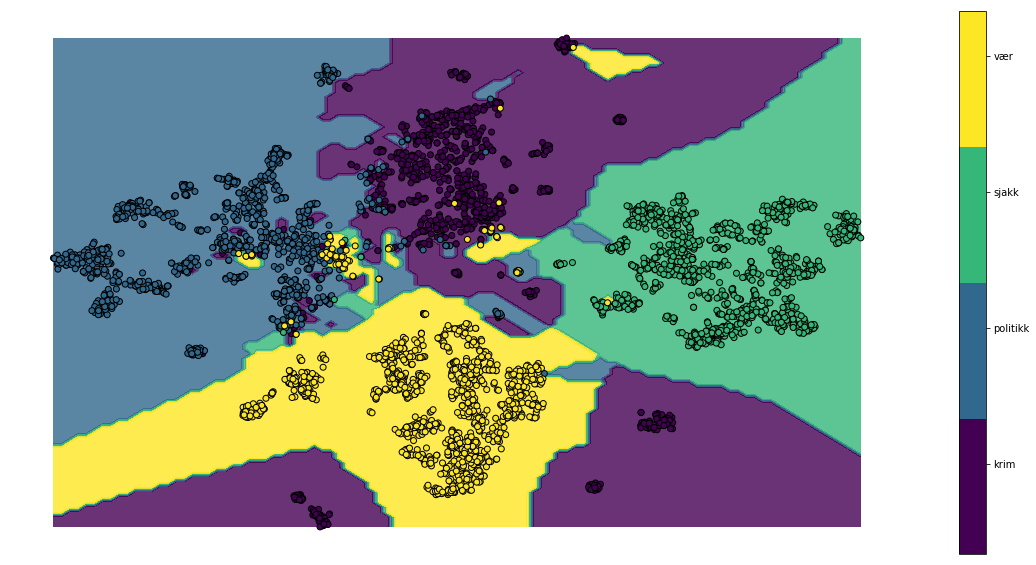

In [32]:
plot_decision_boundary(model, X, y)

## Explanation of predictions

In [98]:
%%capture
pipeline = make_pipeline(vec, model)
pipeline.fit(df.text, df.category)

In [101]:
eli5.show_weights(pipeline, top=20)

In [102]:
eli5.show_prediction(model, df.text.iloc[0], vec=vec)

# What would you need to change to use this model on another data set?

The data set

# Github repo for this demo

<p style="text-align: center;">&nbsp;</p>
<p style="text-align: center;"><span style="font-size: 300%;"><em>github.com/peterts/osloturen-2019</em></span></p>

# Links

The best, easy explanation of ML I've read: https://hackernoon.com/machine-learning-is-the-emperor-wearing-clothes-59933d12a3cc